In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

In [8]:
from src.wess_zumino_model import WessZuminoModel
from src.matrix_to_ps import matrix_to_pse
from src.binary_encodings import standard_encode
from src.qiskit_utilities import pauli_dict_to_op, op_to_trotter

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms.eigensolvers import VQD
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit import BasicAer
from qiskit import qpy
from qiskit import QuantumCircuit, transpile


import scipy.sparse.linalg
import sympy as sp
import numpy as np

from ipywidgets import IntProgress
from IPython.display import display, clear_output 

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import json
import math
import os

In [9]:
def potential(self, n):
    # m*q with m=1
    return -self.mass*self.qs[n]

N=2
wz=WessZuminoModel(N,1.0,potential,'dirichlet')

## TODO 

* Compare in system with and without SSYM preserved

In [10]:
cutoff=16
wz.construct_ham_matrix(cutoff)
e0=scipy.sparse.linalg.eigs(wz.hamMat,k=1,sigma=0.0)[0]
ps=matrix_to_pse(wz.hamMat, standard_encode)
op=pauli_dict_to_op(ps.to_dict())

nq=math.floor(math.log2(wz.hamMat.shape[0]))
if not math.log2(wz.hamMat.shape[0]).is_integer():
    nq+=1

In [12]:
from qiskit.primitives import Estimator, Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
estimator = Estimator()
sampler=Sampler()
fidelity=ComputeUncompute(sampler)

ansatz = RealAmplitudes(nq, entanglement='circular', reps=2)

In [29]:
k=3
betas=[1,1,1]

counts=[]
values=[]
steps=[]

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

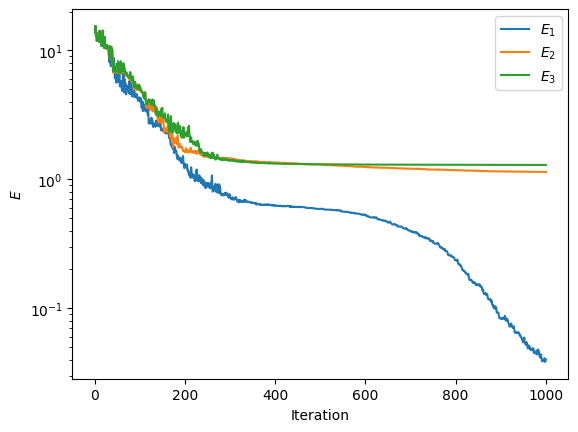

In [30]:
counts=[]
values=[]
steps=[]

vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=1000, tol=1e-4), k=k, betas=betas, callback=callback)
result=vqd.compute_eigenvalues(operator=op)

counts=np.asarray(counts)
steps=np.asarray(steps)
values=np.asarray(values)
for i in range(1,k+1):
    _counts=counts[np.where(steps==i)]
    _values=values[np.where(steps==i)]
    plt.plot(_counts,_values,label=r'$E_{{{}}}$'.format(i))
plt.xlabel(r'Iteration')
plt.ylabel(r'$E$')
plt.yscale('log')
plt.legend(loc='upper right')